# Notebook imports

In [34]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [29]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
SPAM_CAT = 1
HAM_CAT = 0
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

#print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
# Read only the body of message
stream = open(EXAMPLE_FILE, encoding='latin-1')
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
    
stream.close()
email_body = '\n'.join(lines)

#print(email_body)


# Generator Functions

In [6]:
def generate_square(N):
    for my_number in range (N):
        yield my_number**2

In [7]:
for i in generate_square(3):
    print(i, end='->')


0->1->4->

## Email body extraction

In [8]:
def email_body_generator(path):
    for root, dirname, filenames in walk(path):
        for file_name in filenames:

            filepath = join(root, file_name) 
            
            # Read only the body of message
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []
            #skip until find the first '\n' * start of body message *
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                
            stream.close()
            # convert the list of lines in one big string
            email_body = '\n'.join(lines)
            #Return the file name and body of message
            yield file_name, email_body


In [9]:
def df_from_directory(path, classification):
    rows = []
    rows_names = []

    for file_name, email_body in email_body_generator(path):
        # create a list of dictionary
        rows.append({'MESSAGE' : email_body, 'CATEGORY': classification })
        # create a list with files names (will be the index)
        rows_names.append(file_name)

    return pd.DataFrame(rows, index=rows_names)

In [10]:
# Create a DataFrame with analyses for each file in a directory path
# All files are know that contains SPAMs
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)

# Append the second dataframe of SPAMs
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, SPAM_CAT)])

spam_emails.head()

,MESSAGE,CATEGORY
00243.c6e70273fe1cf9e56e26bb6bbeef415d,\n\n\n\n ************...,1
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
# Chalenge: create a dataframe with all non-spam e-mails
# Create a DataFrame with analyses for each file in a directory path
# All files are know that contains SPAMs
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)

# Append the second dataframe of SPAMs
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)])

ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00243.c6e70273fe1cf9e56e26bb6bbeef415d,\n\n\n\n ************...,1
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
00358.87ee38040ac1f42320c7b89628b1850a,Quoting Paul Linehan (plinehan@yahoo.com):\n\n...,0
00359.29dd3e8213e61044d67bc15a6f9a5231,Rick Moen <rick@linuxmafia.com> wrote:\n\n\n\n...,0
00360.fb2dbe3d751033f3e7b125b20ecdb897,\n\nRick Moen <rick@linuxmafia.com> a écrit:\n...,0
00361.ebcde1d624e84623713ac6eddff87943,"On Tue, Aug 13, 2002 at 01:40:21AM +0200, Paul...",0
00362.10247e6e4b5d711a09d7d81c58dcf97c,"On Mon, Aug 12, 2002 at 08:05:58PM +0100, Nick...",0


# Data Cleaning: checking for missing values

In [16]:
# check if any message body is null
data['MESSAGE'].isnull().values.any()

np.False_

In [17]:
# Check if are any empty e-mail
(data['MESSAGE'].str.len() == 0).any()

np.True_

In [18]:
# Count if are any empty e-mail
(data['MESSAGE'].str.len() == 0).sum()

np.int64(3)

In [19]:
# Chalenge: how to count how many null values
data['MESSAGE'].isnull().sum()

np.int64(0)

### Locate empty emails

In [20]:
type(data['MESSAGE'].str.len() == 0)

pandas.core.series.Series

In [21]:
data[data['MESSAGE'].str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [22]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False], shape=(5799,))

# Remove System file entries on Dataframe

In [25]:
data.drop(['cmds'], inplace=True)

KeyError: "['cmds'] not found in axis"

In [26]:
# sanity check
(data['MESSAGE'].str.len() == 0).sum()
data.shape

(5796, 2)

# Add document ID to track Emails in Dataset

In [27]:
document_ids =range (0, len(data.index))
document_ids

# create the column
data['DOC_ID'] = document_ids

# preserve the file_name colum and add new index
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()


,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,\n\n\n\n ************...,1,00243.c6e70273fe1cf9e56e26bb6bbeef415d
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
3,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
4,##############################################...,1,00004.eac8de8d759b7e74154f142194282724


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,Quoting Paul Linehan (plinehan@yahoo.com):\n\n...,0,00358.87ee38040ac1f42320c7b89628b1850a
5792,Rick Moen <rick@linuxmafia.com> wrote:\n\n\n\n...,0,00359.29dd3e8213e61044d67bc15a6f9a5231
5793,\n\nRick Moen <rick@linuxmafia.com> a écrit:\n...,0,00360.fb2dbe3d751033f3e7b125b20ecdb897
5794,"On Tue, Aug 13, 2002 at 01:40:21AM +0200, Paul...",0,00361.ebcde1d624e84623713ac6eddff87943
5795,"On Mon, Aug 12, 2002 at 08:05:58PM +0100, Nick...",0,00362.10247e6e4b5d711a09d7d81c58dcf97c


# Save to file using Pandas

In [30]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages Visualised (Pie chart)

In [31]:
data['CATEGORY'].value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [32]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

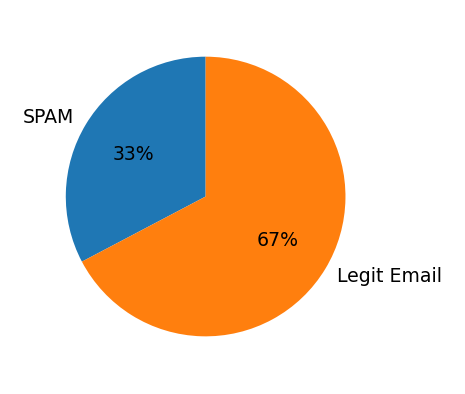

In [49]:
category_names = ['SPAM', 'Legit Email']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

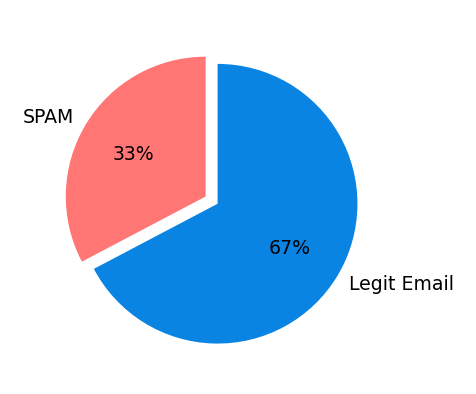

In [51]:
category_names = ['SPAM', 'Legit Email']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#0984e3']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%',
        colors=custom_colors, explode=[0, 0.1])
plt.show()